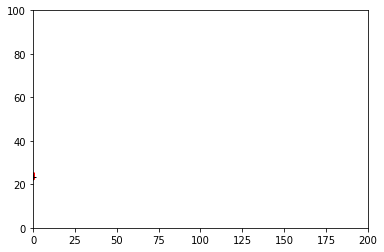

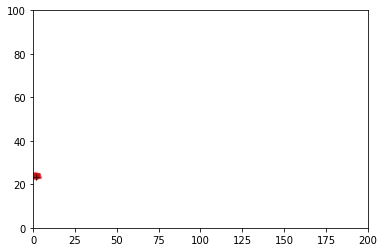

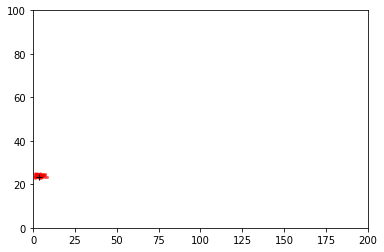

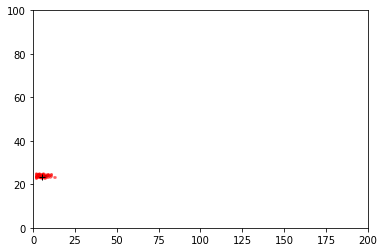

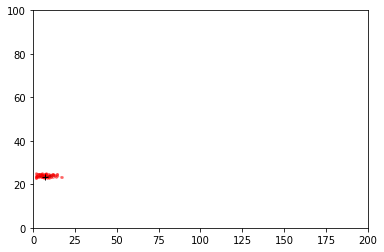

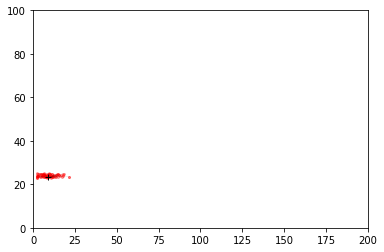

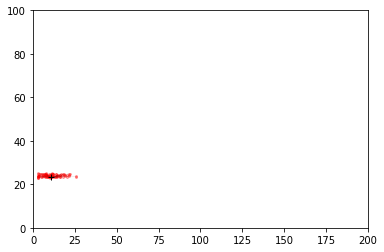

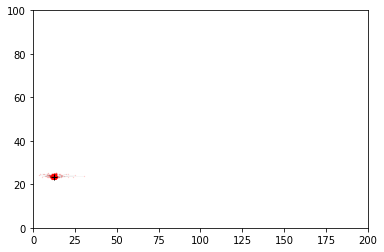

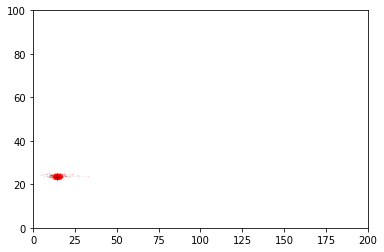

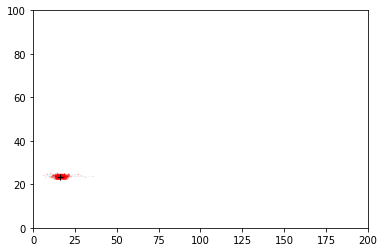

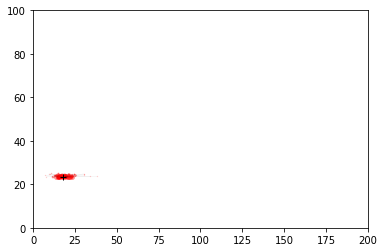

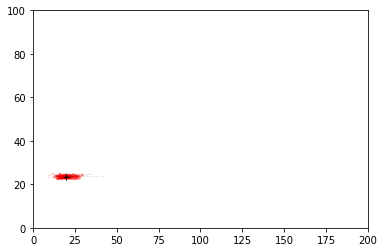

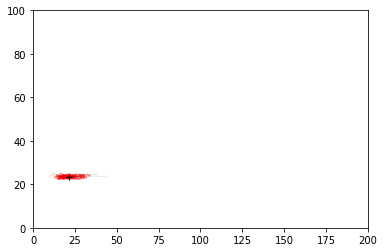

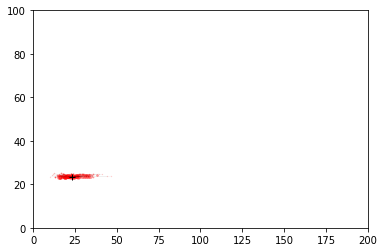

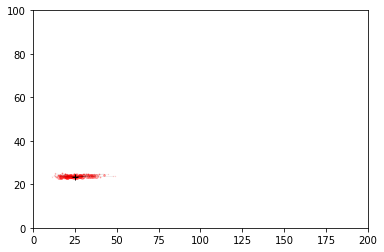

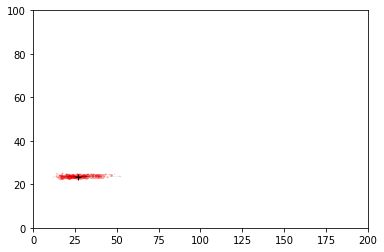

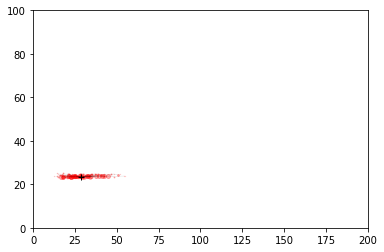

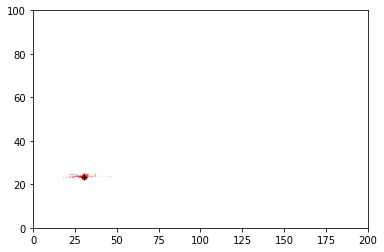

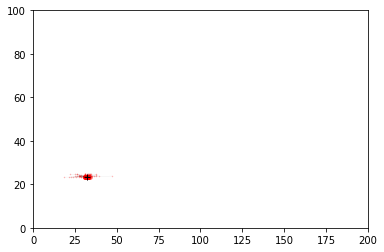

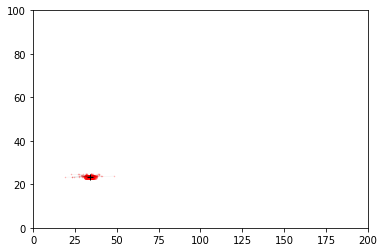

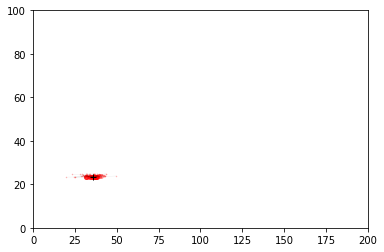

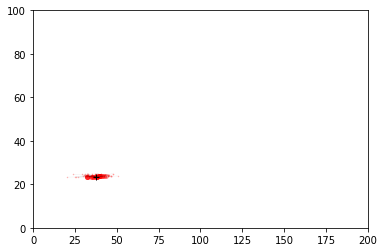

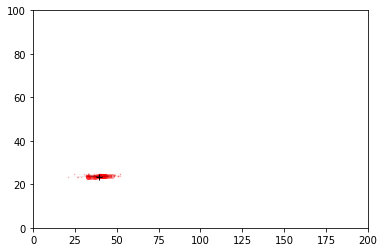

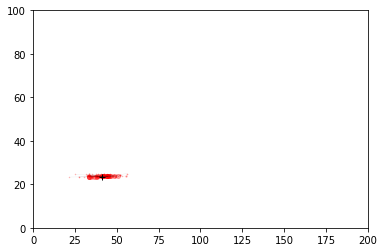

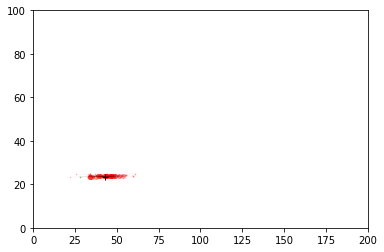

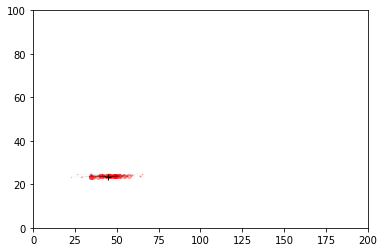

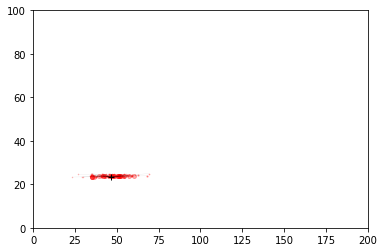

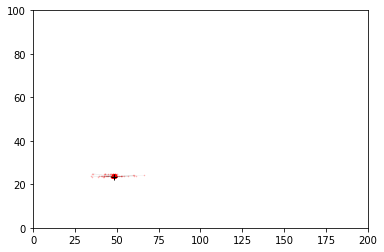

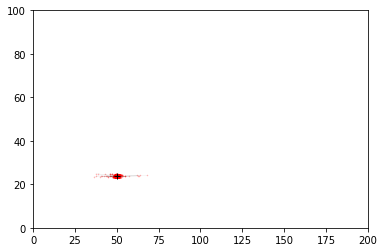

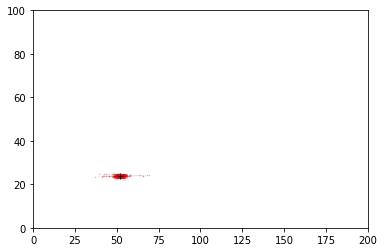

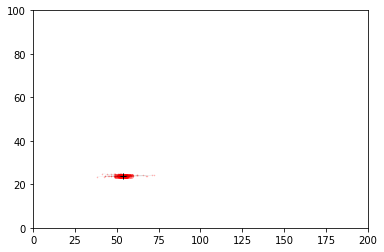

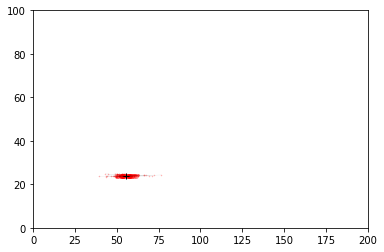

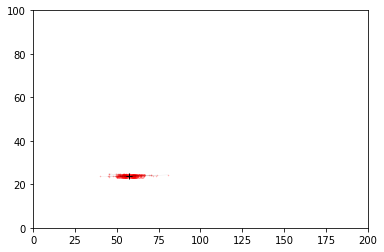

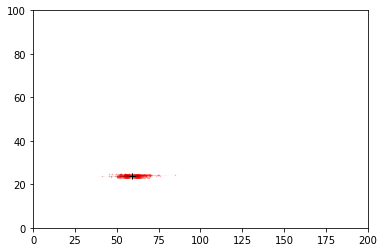

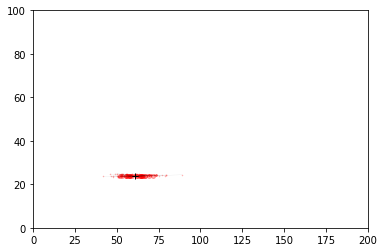

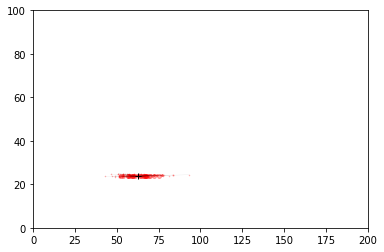

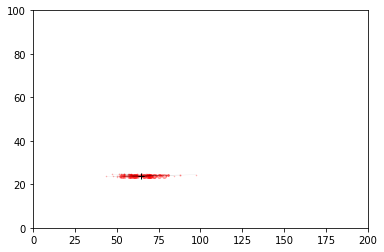

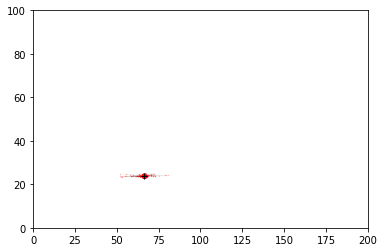

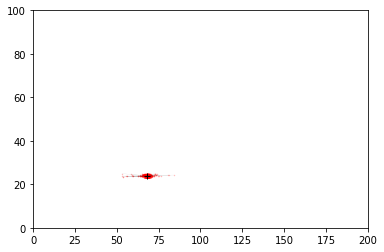

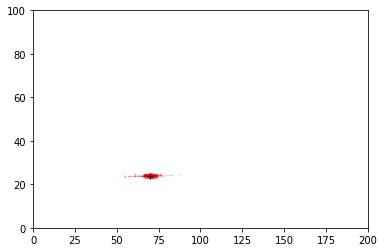

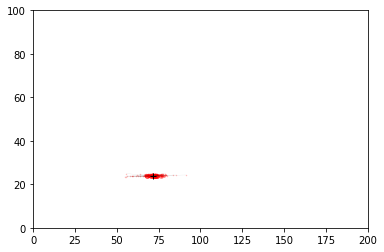

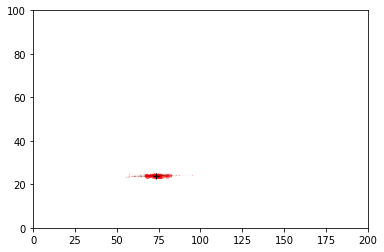

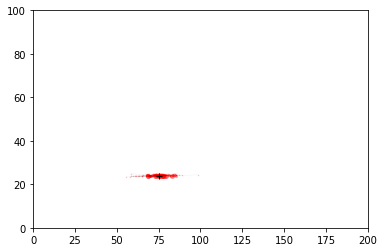

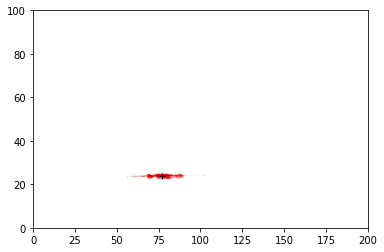

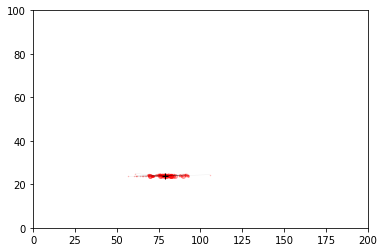

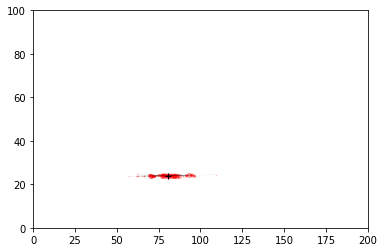

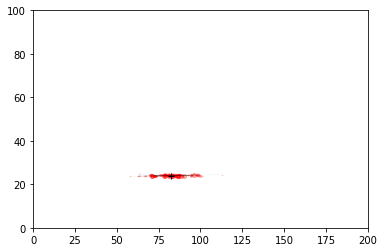

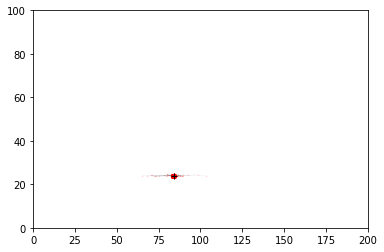

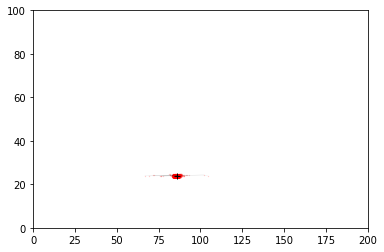

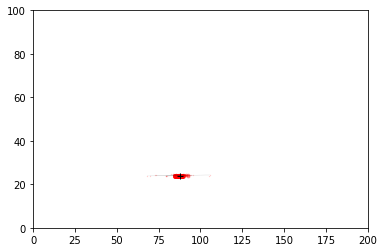

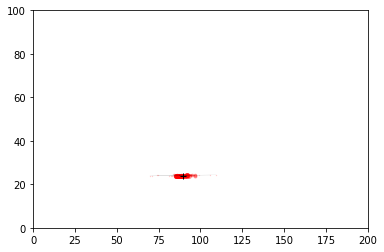

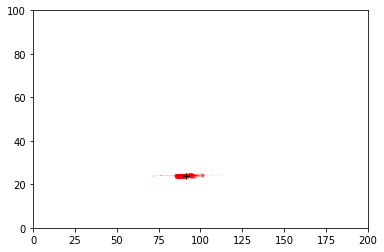

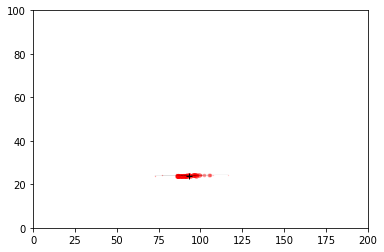

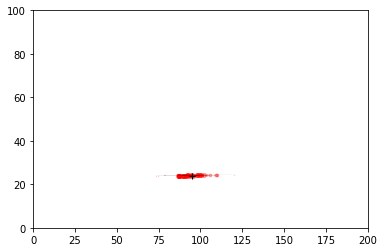

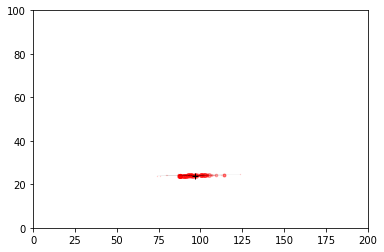

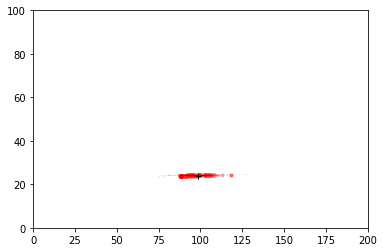

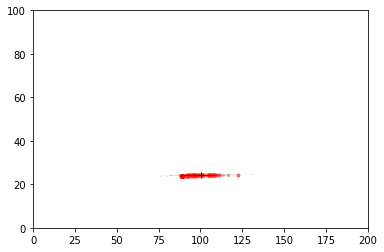

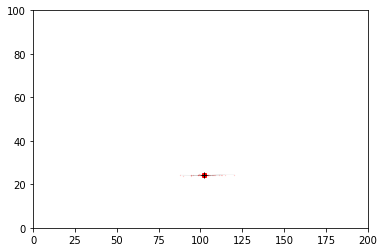

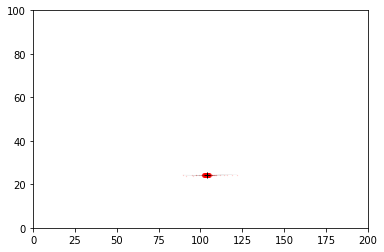

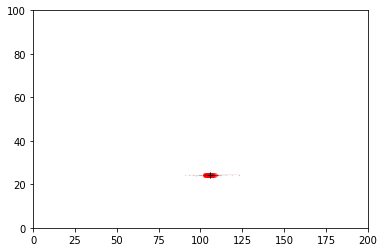

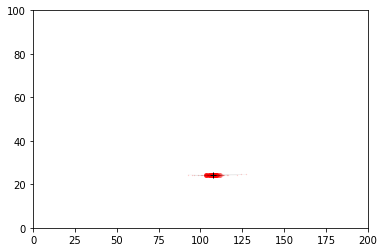

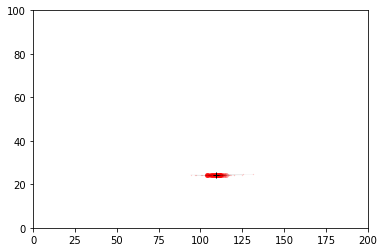

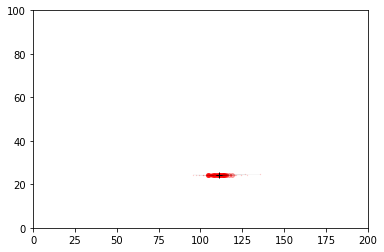

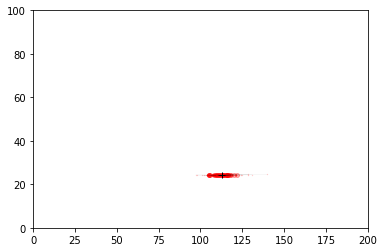

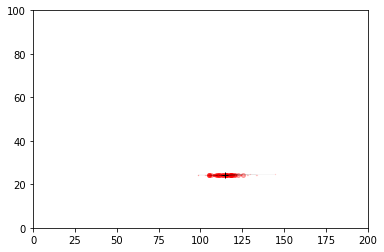

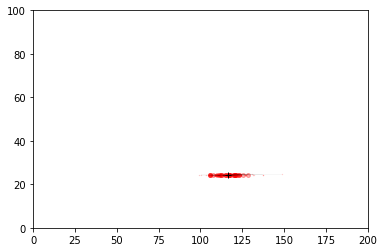

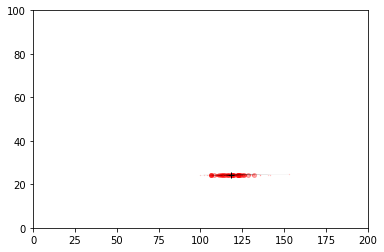

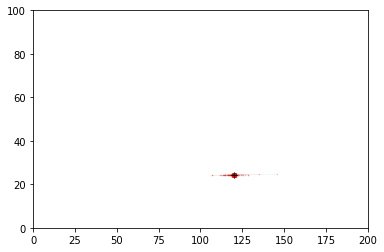

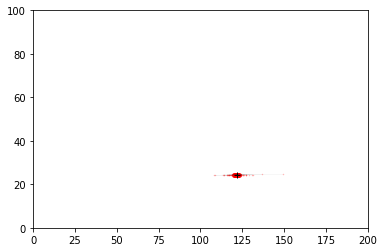

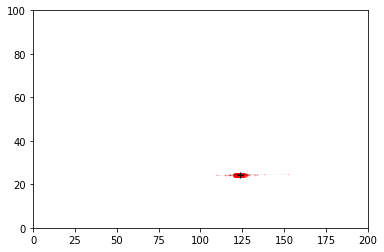

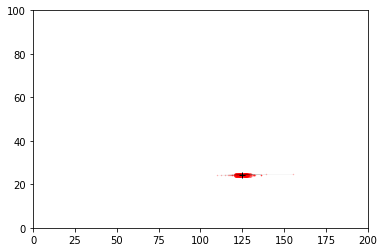

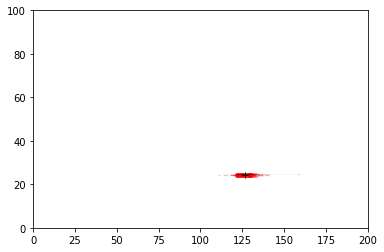

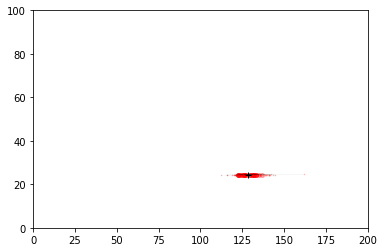

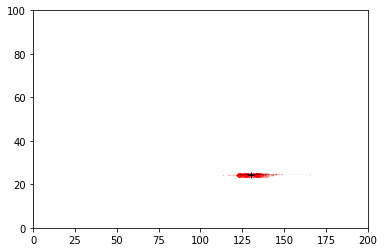

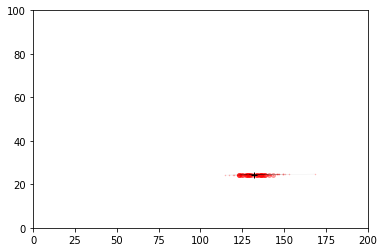

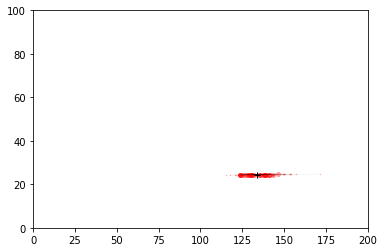

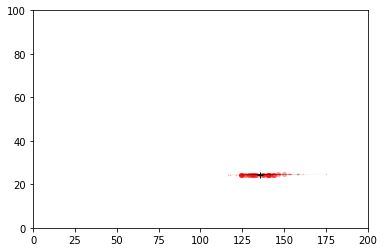

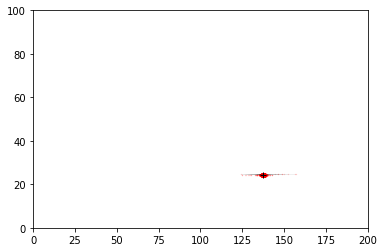

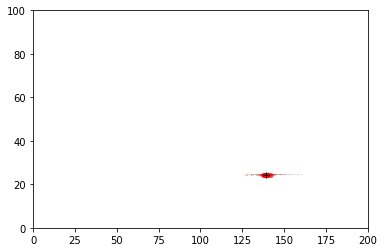

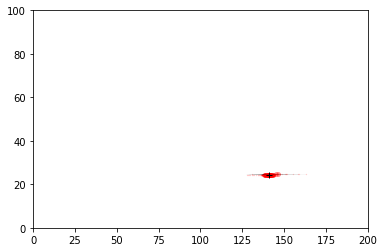

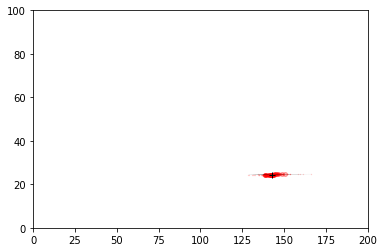

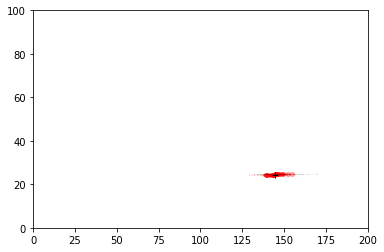

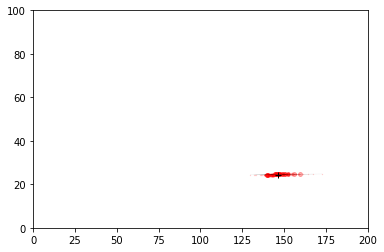

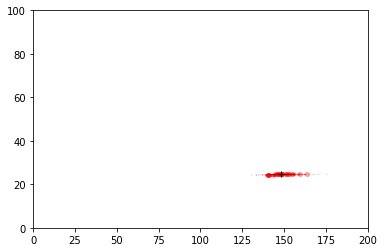

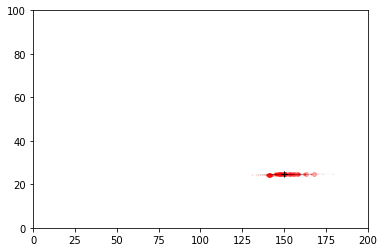

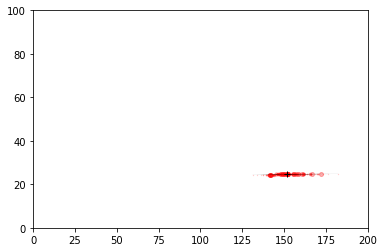

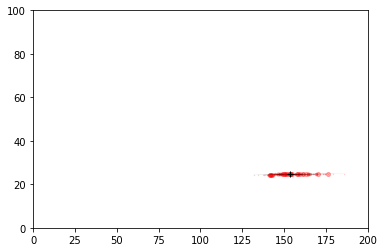

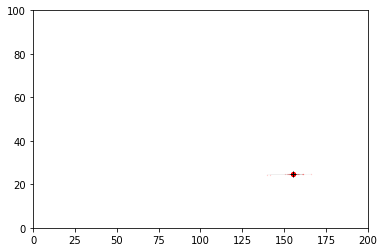

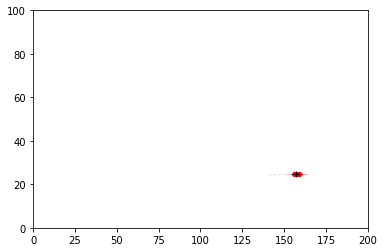

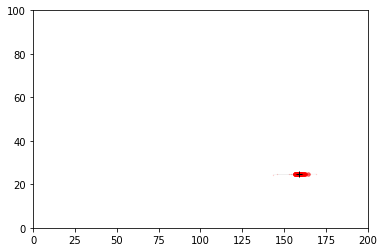

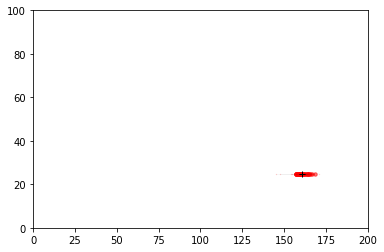

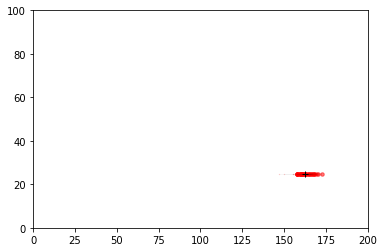

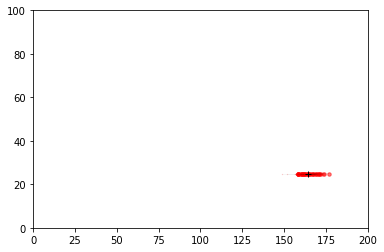

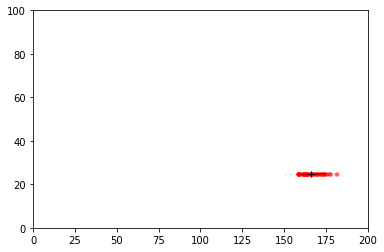

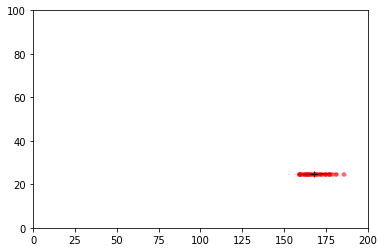

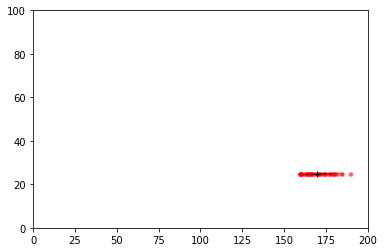

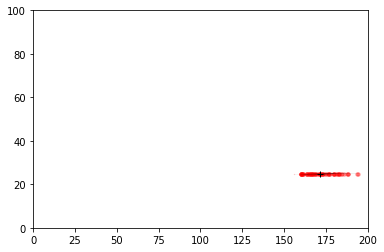

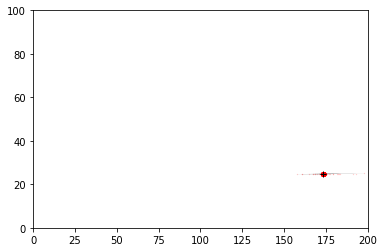

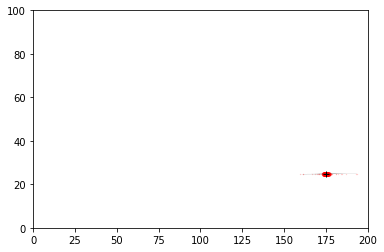

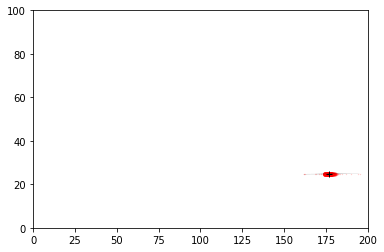

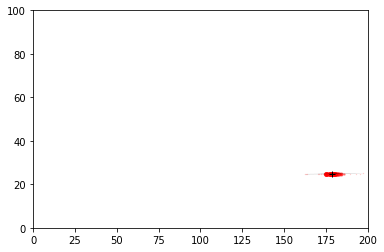

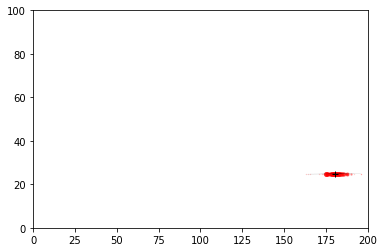

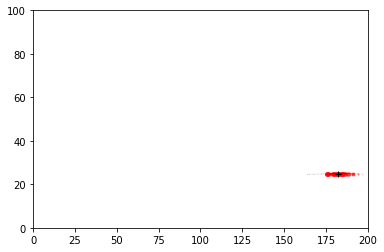

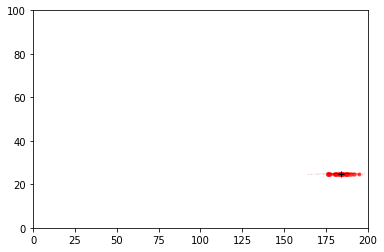

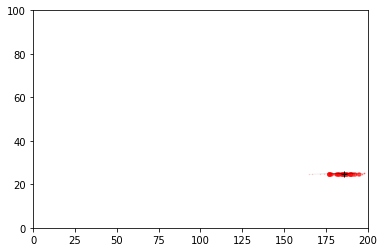

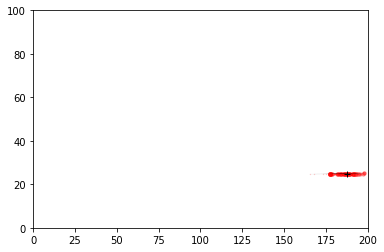

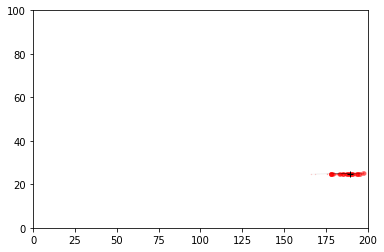

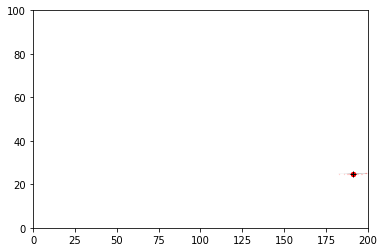

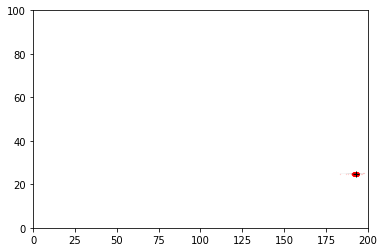

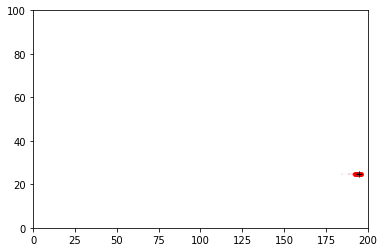

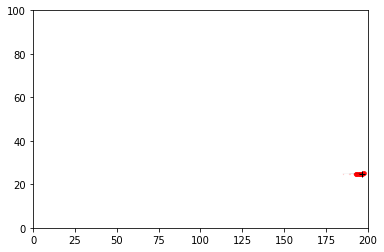

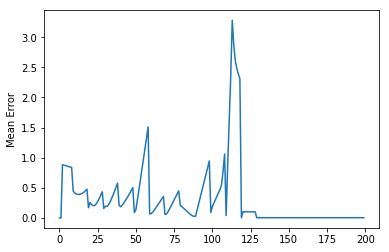

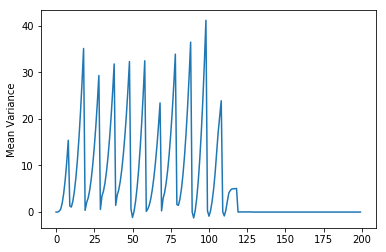

Max mean error =  3.2823212024886046
Average mean error =  0.3172209069818225
Max mean variance =  41.14682128997542
Average mean variance =  6.304792047621953


In [36]:
# sspmm.py
'''
StationSim (aka Mike's model) converted into python.

Todos:
multiprocessing
profile functions
'''
import numpy as np
import matplotlib.pyplot as plt
from copy import deepcopy


def error(text='Self created error.'):
    from sys import exit
    print()
    exit(text)
    return


class NextRandom:
    # To find random number useage type 'random.np_', or even 'random'

    def __init__(self):
        np.random.seed(303)
        self.random_number_usage = 0
        return

    def np_uniform(self, high=1, low=0, shape=1):
        r = np.random.random(shape)
        r = r * (high - low)
        self.random_number_usage += np.size(r)
        return r

    def np_gaussian(self, mu=0, sigma=1, shape=1):
        r = np.random.standard_normal(shape)
        r = r * sigma + mu #r * sigma**2 + mu
        self.random_number_usage += np.size(r)
        return r

    def np_integer(self, high=1, low=0, shape=1):
        r = np.random.randint(low, high + 1, shape)
        self.random_number_usage += np.size(r)
        return r


class Agent:

    def __init__(self, model):
        self.unique_id = model.agent_count
        model.agent_count += 1
        self.active = 0  # 0 = not started, 1 = started, 2 = finished
        # Location
        entrance = random.np_integer(model.entrances - 1)
        self.location = model.loc_entrances[entrance][0]
        # Parameters
        self.loc_desire = model.loc_exits[random.np_integer(model.exits - 1)][0]
        return

    def step(self, model):
        if self.active == 0:
            self.activate(model)
        elif self.active == 1:
            self.move(model)
            if model.do_save:
                self.save()
            self.exit_query(model)
        return

    def activate(self, model):
        self.speed_desire = max(random.np_gaussian(model.speed_desire_max), model.speed_desire_min)
        new_location = self.location
        new_location[1] += model.entrance_space * random.np_uniform(-.5, +.5)
        # Empty space to step off of 'train'
        self.separation = model.initial_separation
        if not self.collision(model, new_location):
            self.active = 1
            model.pop_active += 1
            self.location = new_location
            self.separation = model.separation
            # Save
            if model.do_save:
                self.start_time = model.time
                self.history_loc = []
        return

    def move(self, model):
        '''
        Description:
            This mechanism moves the agent. It checks certain conditions for collisions at decreasing speeds.
            First check for direct new_location in the desired direction.
            Second check for a new_location in a varied desired direction.
            Third check for a new_location with a varied current direction.

        Dependencies:
            collision - any agents in radius
                neighbourhood - find neighbours in radius
            lerp      - linear extrapolation

        Arguments:
            self

        Returns:
            new_location
        '''
        # Decreasing Speeds
        speeds = np.linspace(self.speed_desire, model.speed_min, 15)
        for speed in speeds:
            new_location = self.lerp(self.loc_desire, self.location, speed)
            if not self.collision(model, new_location):
                break
        # Wiggle
        if speed == model.speed_min:
            new_location = self.location + random.np_integer(low=-1, high=+1, shape=2)
        # Boundary check
        within_bounds = all(model.boundaries[0] <= new_location) and all(new_location <= model.boundaries[1])
        if not within_bounds:
            new_location = np.clip(new_location, model.boundaries[0], model.boundaries[1])
        # Move
        self.location = new_location
        return

    def collision(self, model, new_location):
        '''
        Description:
            Determine whether or not there is another object at this location.
            Requires get neighbour from mesa?

        Dependencies:
            neighbourhood - find neighbours in radius

        Arguments:
            model.boundaries
                ((f, f), (f, f))
                A pair of tuples defining the lower limits and upper limits to the rectangular world.
            new_location
                (f, f)
                The potential location of an agent.

        Returns:
            collide
                b
                The answer to whether this position is blocked
        '''
        within_bounds = all(model.boundaries[0] <= new_location) and all(new_location <= model.boundaries[1])
        if not within_bounds:
            collide = True
        elif self.neighbourhood(model, new_location):
            collide = True
        else:
            collide = False
        return collide

    def neighbourhood(self, model, new_location, just_one=True, forward_vision=True):
        '''
        Description:
            Get agents within the defined separation.

        Arguments:
            self.unique_id
                i
                The current agent's unique identifier
            self.separation
                f
                The radius in which to search
            model.agents
                <agent object>s
                The set of all agents
            new_location
                (f, f)
                A location tuple
            just_one
                b
                Defines if more than one neighbour is needed.
            forward_vision
                b
                Restricts separation radius to only infront.

        Returns:
            neighbours
                <agent object>s
                A set of agents in a region
        '''
        neighbours = []
        for agent in model.agents:
            if agent.active == 1:
                if forward_vision and agent.location[0] < new_location[0]:
                    distance = self.separation + 1
                else:
                    distance = np.linalg.norm(new_location - agent.location)
                if distance < self.separation and agent.unique_id != self.unique_id:
                    neighbours.append(agent)
                    if just_one:
                        break
        return neighbours

    def lerp(self, loc1, loc2, speed):
        '''
        Description:
            Linear extrapolation at a constant rate
            https://en.wikipedia.org/wiki/Linear_interpolation

        Arguments:
            loc1
                (f, f)
                Point One defining the destination position
            loc2
                (f, f)
                Point Two defining the agent position
            speed
                f
                The suggested speed of the agent

        Returns:
            loc
                (f, f)
                The location if travelled at this speed
        '''
        distance = np.linalg.norm(loc1 - loc2)
        loc = loc2 + speed * (loc1 - loc2) / distance
        return loc

    def save(self):
        self.history_loc.append(self.location)
        return

    def exit_query(self, model):
        if np.linalg.norm(self.location - self.loc_desire) < model.exit_space:
            self.active = 2
            model.pop_active -= 1
            model.pop_finished += 1
            if model.do_save:
                model.time_taken.append(model.time - self.start_time)
        return


class Model:

    def __init__(self, params):
        for key, value in params.items():
            setattr(self, key, value)
        # Batch Details
        self.time = 0
        if self.do_save:
            self.time_taken = []
        # Model Parameters
        self.boundaries = np.array([[0, 0], [self.width, self.height]])
        self.pop_active = 0
        self.pop_finished = 0
        # Initialise
        self.initialise_gates()
        self.initialise_agents()
        return

    def step(self):
        self.time += 1
        if self.time > 2:  # For animation purposes
            for agent in self.agents:
                agent.step(self)
        return

    def initialise_gates(self):
        # Entrances
        self.loc_entrances = np.zeros((self.entrances, 2))
        self.loc_entrances[:, 0] = 0
        if self.entrances == 1:
            self.loc_entrances[0, 1] = self.height / 2
        else:
            self.loc_entrances[:, 1] = np.linspace(self.height / 4, 3 * self.height / 4, self.entrances)
        # Exits
        self.loc_exits = np.zeros((self.exits, 2))
        self.loc_exits[:, 0] = self.width
        if self.exits == 1:
            self.loc_exits[0, 1] = self.height / 2
        else:
            self.loc_exits[:, 1] = np.linspace(self.height / 4, 3 * self.height / 4, self.exits)
        return

    def initialise_agents(self):
        self.agent_count = 0
        self.agents = list([Agent(self) for _ in range(self.pop_total)])
        return

    def agents2state(self):
        state = np.ravel([agent.location for agent in self.agents])
        return state

    def state2agents(self, state):
        for i in range(len(self.agents)):
            self.agents[i].location = state[2 * i:2 * i + 2]
        return

    def batch(self):
        for i in range(self.batch_iterations):
            self.step()
            if self.do_ani:
                self.ani_agents()
            if self.pop_finished == self.pop_total:
                print('Everyone made it!')
                break
        if self.do_save:
            self.stats()
            self.plot_subplots()
        return

    def ani_agents(self):
        plt.figure(1)
        plt.clf()
        for agent in self.agents:
            if agent.active == 1:
                plt.plot(*agent.location, '.k')
        plt.axis(np.ravel(self.boundaries, 'F'))
        plt.pause(1 / 30)
        return

    def plot_subplots(self):
        _, (ax1, ax2) = plt.subplots(2)
        for agent in self.agents:
            if agent.active == 2 and agent.unique_id < 50:
                locs = np.array(agent.history_loc).T
                ax1.plot(locs[0], locs[1], linewidth=.5)
        ax1.axis(np.ravel(self.boundaries, 'F'))
        ax2.hist(self.time_taken)
        plt.show()
        return

    def stats(self):
        print()
        print('Stats:')
        print('Finish Time: ' + str(self.time))
        print('Random number usage: ' + str(random.random_number_usage))
        print('Active / Finished / Total agents: ' + str(self.pop_active) +
              '/' + str(self.pop_finished) + '/' + str(self.pop_total))
        print('Average time taken: ' + str(np.mean(self.time_taken)) + 's')
        return

'''
A particle filter to model the dynamics of the
state of the model as it develops in time.

Parameters:

'number_of_particles': The number of particles used to simulate the model
'particle_std': The standard deviation of the noise added to particle states
'model_std': The standard deviation of the noise added to model observations
'do_copies': Boolean to determine if a copy of base model or new models should
    be used for particles
'do_neff': Boolean to determine if particles should only be resampled when 
    weights are small enough
'do_save': Boolean to determine if particle filter data should be saved
'do_ani': Boolean to determine if particle filter data should be animated
    and displayed
'''
class ParticleFilter:
    
    # update all documentation
    # update so that pf runs until all base model
    # agents are finished
    # Change iterations to time_stop
    # When we add noise, the particle agents may end up in 
    # the same location or collide or something
    # Use map for any simple for loops
    # When adding noise to measured state, do we want different Gaussian noise
    # for each state variable or one gaussian for noise in x direction and one
    # gaussian for noise in y direction?
    # Add boolean to decide if you want to plot particles or if you want to 
    # plot the mean of the particles instead
    # In the random class above, changed r * sigma**2 + mu to r * sigma + mu
    # What happens when agent has a very slow speed and particles
    # all have a slightly faster speed? (EXTREME SPEEDS)
    '''
    Initialise Particle Filter
    
    Firstly, set all attributes using filter parameters. Set time and
    initialise base model using model parameters. Initialise particle
    models using a deepcopy of base model. Determine particle filter 
    dimensions, set state of particles to the state of the base model,
    and then initialise all remaining arrays. 
    '''
    def __init__(self, Model, model_params, filter_params):
        
        for key, value in filter_params.items():
            setattr(self, key, value)
        self.time = 0
        self.base_model = Model(model_params)
        self.models = list([deepcopy(self.base_model) for _ in range(self.number_of_particles)])  
        self.dimensions = len(self.base_model.agents2state())
        self.states = np.empty((self.number_of_particles, self.dimensions))
        for particle in range(self.number_of_particles):
            self.states[particle,:] = self.base_model.agents2state()
        self.weights = np.ones(self.number_of_particles)
        if self.do_save:
            self.means = []
            self.mean_errors = []
            self.variances = []

    '''
    Step Particle Filter
    
    Loop through process. Predict the base model and particles
    forward and then reweight particles based on distance to 
    base model. If the resample window has been reached, resample 
    particles choosing particles with higher weights. Then save
    and animate the data.
    '''
    def step(self):
        
        for _ in range(self.number_of_iterations):
            self.predict()
            if self.time % self.resample_window == 0:
                self.reweight()
                self.resample()

            if self.do_save:
                self.save()
            if self.do_ani:
                self.ani()
                
        if self.do_save:
            self.plot_save()
        return

    '''
    Predict
    
    Increment time. Step the base model. For each particle,
    assign the current particle state to the agents of that
    particle model. Then, step the particle model and then 
    reassign the agent locations to the particle state with
    some noise. This is the main interaction between the 
    model and the particle filter.
    '''
    def predict(self):
        self.time += 1
        self.base_model.step()
        for particle in range(self.number_of_particles): 
            self.models[particle].step()
            self.states[particle] = (self.models[particle].agents2state()
                                     + random.np_gaussian(0, self.particle_std**2, 
                                                          shape=self.states[particle].shape))
            self.models[particle].state2agents(self.states[particle])
        return
    
    '''
    Reweight
    
    Add noise to the particle states and the base model state. Calculate 
    the distance between the particle states and the measured base model 
    state and then calculate the new particle weights as 1/distance. 
    Add a small term to avoid dividing by 0. Normalise the weights.
    '''
    def reweight(self):
        measured_state = (self.base_model.agents2state() 
                          + random.np_gaussian(0, self.model_std**2, shape=self.states.shape))
        distance = np.linalg.norm(self.states - measured_state, axis=1)
        self.weights = 1 / (distance + 1e-99)
        self.weights /= np.sum(self.weights)
        return

    '''
    Resample
    
    Calculate a random partition of (0,1) and then 
    take the cumulative sum of the particle weights.
    Carry out a systematic resample of particles.
    Set the new particle states and weights and then
    update agent locations in particle models.
    '''
    def resample(self):
        offset_partition = ((np.arange(self.number_of_particles) 
                             + random.np_uniform()) / self.number_of_particles)
        cumsum = np.cumsum(self.weights)
        i, j = 0, 0
        indexes = np.zeros(self.number_of_particles, 'i')
        while i < self.number_of_particles and j < self.number_of_particles:
            if offset_partition[i] < cumsum[j]:
                indexes[i] = j
                i += 1
            else:
                j += 1
                
        self.states[:] = self.states[indexes]
        self.weights[:] = self.weights[indexes]
        
        for particle in range(self.number_of_particles):
            self.models[particle].state2agents(self.states[particle])
        return

    '''
    Save and Plot Save
    
    Calculate mean and variance of particles and calculate
    mean error between the mean and the true base model 
    state. Plot mean error and mean variance. 
    '''
    def save(self):
        
        mean = np.average(self.states, weights=self.weights, axis=0)
        variance = np.average((self.states - mean)**2, weights=self.weights, axis=0)
        
        self.means.append(mean[:])
        self.variances.append(np.average(variance))
        
        truth_state = self.base_model.agents2state()
        self.mean_errors.append(np.linalg.norm(mean - truth_state, axis=0))
        
        return
    
    def plot_save(self):
        plt.figure(2)
        plt.plot(self.mean_errors)
        plt.ylabel('Mean Error')
        plt.show()
        
        plt.figure(3)
        plt.plot(self.variances)
        plt.ylabel('Mean Variance')
        plt.show()
        
        print('Max mean error = ',max(self.mean_errors))
        print('Average mean error = ',np.average(self.mean_errors))
        print('Max mean variance = ',max(self.variances))
        print('Average mean variance = ',np.average(self.variances))

    def ani(self):
        
        if any([agent.active == 1 for agent in self.base_model.agents]):
    
            plt.figure(1)
            plt.clf()
            
            markersizes = self.weights
            if np.std(markersizes) != 0:
                markersizes *= 4 / np.std(markersizes)   # revar
            markersizes += 4 - np.mean(markersizes)  # remean

            particle = -1
            for model in self.models:
                particle += 1
                markersize = np.clip(markersizes[particle], .5, 8)
                for agent in model.agents[:self.agents_to_visualise]:
                    if agent.active == 1:
                        unique_id = agent.unique_id
                        if self.base_model.agents[unique_id].active == 1:
                            locs = np.array([self.base_model.agents[unique_id].location, agent.location]).T
                            plt.plot(*locs, '-k', alpha=.1, linewidth=.3)
                            plt.plot(*agent.location, '.r', alpha=.3, markersize=markersize)
            
            for agent in self.base_model.agents:
                if agent.active == 1:
                    plt.plot(*agent.location, '+k')
            
            plt.axis(np.ravel(self.base_model.boundaries, 'F'))
            plt.pause(1 / 4)
        return


if __name__ == '__main__':
    random = NextRandom()
    model_params = {
        'width': 200,
        'height': 100,
        'pop_total': 1,
        'entrances': 3,
        'entrance_space': 2,
        'exits': 2,
        'exit_space': 2,
        'speed_min': .1,
        'speed_desire_min': .5,
        'speed_desire_max': 2,
        'initial_separation': 1,
        'separation': 5,
        'batch_iterations': 50,
        'do_save': True,
        'do_ani': True
    }
    if not True:
        # Run the model
        Model(model_params).batch()
    else:
        # Run the particle filter
        filter_params = {
            'number_of_particles': 100,
            'number_of_iterations': 200,
            'resample_window': 10,
            'agents_to_visualise': 2,
            'particle_std': 0,
            'model_std': 0,
            'do_save': True,
            'do_ani': True
        }
        pf = ParticleFilter(Model, model_params, filter_params)
        pf.step()

        



In [ ]:
Max mean error =  43.08445255759689
Average mean error =  17.265604121089034
Max mean variance =  188.66096719873403
Average mean variance =  68.34504050282214

